# Importing Libraries

In [1]:
import ase.io # for reading *.xyz
import pandas as pd # for dataframes
from math import ceil
import itertools
from IPython.display import clear_output

import matplotlib.pyplot as plt # for plotting error distribution
from matplotlib.colors import Normalize, LogNorm, to_hex
from matplotlib.cm import (
    plasma,
    inferno,
    magma,
    viridis,
    cividis,
    turbo,
    ScalarMappable,
)

from bokeh.plotting import figure, output_notebook
from bokeh.io import show
from bokeh.sampledata.periodic_table import elements
from bokeh.transform import dodge
from bokeh.models import (
    ColumnDataSource,
    LinearColorMapper,
    LogColorMapper,
    ColorBar,
    BasicTicker,
)

# Setting Variables and Functions

In [2]:
DATASET_LOCATION = "../data_structures_errors.xyz" # should be in the same directory as the repository
FIGURE_SIZE_X = 20
FIGURE_SIZE_Y = FIGURE_SIZE_X/2
font = {'size'   : 27}
plt.rc('font', **font)

In [14]:
def plot_scatter_sorted(df_sorted, method):
    df_sorted.sort_values(by=method, inplace=True)
    plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
    plt.title(f"Scatter plot of error / eV against {method}")
    plt.xlabel(method)
    plt.ylabel("error / eV")
    plt.ylim(-1.1*df_sorted["error / eV"].abs().max(), 1.1*df_sorted["error / eV"].abs().max())
    plt.scatter(df_sorted[method], df_sorted['error / eV'].abs(), s=10, color='#6E9EEB')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()

def rolling_sorted_multiplot(df_sorted, method, rolling_amount):
    df_sorted.sort_values(by=method, inplace=True)
    plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y), facecolor="#E2ECFB")
    plt.axes().set_facecolor("#E2ECFB")
    plt.title(f"Rolling({rolling_amount}) line plot of error / eV against {method} with std(), mean(), median()")
    plt.xlabel(method)
    plt.ylabel("error / eV")
    plt.plot(df_sorted[method], df_sorted['error / eV'].abs().rolling(rolling_amount).std(), label="std()", color="#6E9EEB")
    plt.plot(df_sorted[method], df_sorted['error / eV'].abs().rolling(rolling_amount).mean(), label="mean()", color="#14F2E0")
    plt.plot(df_sorted[method], df_sorted['error / eV'].abs().rolling(rolling_amount).median(), label="median()", color="#F320FA")
    plt.axhline(y=0, color='r', linestyle='--')
    plt.legend(loc='best')
    plt.show()

def plot_element(element_df, error):
    plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
    plt.title(f"Bar plot of {error} against elements present (overlapping)")
    plt.xlabel('Element')
    plt.ylabel(error)
    plt.bar(element_df["symbol"],
            element_df[error],
            color=[(1, 0, 0, 1) if element_df.loc[element, "symbol"] == "O"
                    else (0.8, 0, 1, element_df.loc[element, "frequency"]/element_df.loc[0, "frequency"]) if element_df.loc[element, "symbol"] == "C" or element_df.loc[element, "symbol"] == "N" or element_df.loc[element, "symbol"] == "H"
                    else (31/255, 119/255, 180/255, element_df.loc[element, "frequency"]/element_df.loc[9, "frequency"])  
                    for element in element_df.index])
    plt.show()

def plot_adsorbate(df, error):
    df.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
    plt.title(f"Bar plot of {error} against adsorbate")
    plt.xlabel('Adsorbate')
    plt.ylabel(error)
    plt.gcf().autofmt_xdate()
    plt.bar([''.join(df.loc[i, "formula list"]) for i in range(len(df))],
            df[error],
            color=["#14F2E0" + f'{ceil(255*df.loc[adsorbate, "frequency"]/adsorbate_df.loc[0:3, "frequency"].max()):0{2}X}' if df.loc[adsorbate, "adsorbate class"] == 'O/H Only'
                    else "#41C8E5" + f'{ceil(255*df.loc[adsorbate, "frequency"]/adsorbate_df.loc[4:14, "frequency"].max()):0{2}X}' if df.loc[adsorbate, "adsorbate class"] == 'C1'
                    else "#9A75F0" + f'{ceil(255*df.loc[adsorbate, "frequency"]/adsorbate_df.loc[15:32, "frequency"].max()):0{2}X}' if df.loc[adsorbate, "adsorbate class"] == 'C2'
                    else "#F320FA" + f'{ceil(255*df.loc[adsorbate, "frequency"]/adsorbate_df.loc[33:, "frequency"].max()):0{2}X}'
                    for adsorbate in df.index])
    plt.show()

def ptable_plotter( # adapted from https://github.com/arosen93/ptable_trends
    data_elements,
    data_list,
    width=1050,
    cmap="plasma",
    alpha=0.65,
    log_scale=False,
    cbar_height=None,
    cbar_standoff=12,
    cbar_fontsize=14,
    blank_color="#c4c4c4",
    under_value=None,
    under_color="#140F0E",
    over_value=None,
    over_color="#140F0E",
    special_elements=None,
    special_color="#6F3023",
) -> figure: 

    # Assign color palette based on input argument
    if cmap == "plasma":
        cmap = plasma
        bokeh_palette = "Plasma256"
    elif cmap == "inferno":
        cmap = inferno
        bokeh_palette = "Inferno256"
    elif cmap == "magma":
        cmap = magma
        bokeh_palette = "Magma256"
    elif cmap == "viridis":
        cmap = viridis
        bokeh_palette = "Viridis256"
    elif cmap == "cividis":
        cmap = cividis
        bokeh_palette = "Cividis256"
    elif cmap == "turbo":
        cmap = turbo
        bokeh_palette = "Turbo256"
    else:
        pass

    # Define number of and groups
    period_label = ["1", "2", "3", "4", "5", "6", "7"]
    group_range = [str(x) for x in range(1, 19)]

    period_label.append("blank")

    # Define matplotlib and bokeh color map
    if log_scale:
        for datum in data_list:
            if datum < 0:
                raise ValueError(
                    f"Entry for element {datum} is negative but log-scale is selected"
                )
        color_mapper = LogColorMapper(
            palette=bokeh_palette, low=min(data_list), high=max(data_list)
        )
        norm = LogNorm(vmin=min(data_list), vmax=max(data_list))
    else:
        color_mapper = LinearColorMapper(
            palette=bokeh_palette, low=min(data_list), high=max(data_list)
        )
        norm = Normalize(vmin=min(data_list), vmax=max(data_list))
    color_scale = ScalarMappable(norm=norm, cmap=cmap).to_rgba(data_list, alpha=None)

    # Set blank color
    color_list = [blank_color] * len(elements)

    # Compare elements in dataset with elements in periodic table
    for i, data_element in enumerate(data_elements):
        element_entry = elements.symbol[
            elements.symbol.str.lower() == data_element.lower()
        ]
        if element_entry.empty == False:
            element_index = element_entry.index[0]
        else:
            pass
        if under_value is not None and data_list[i] <= under_value:
            color_list[element_index] = under_color
        elif over_value is not None and data_list[i] >= over_value:
            color_list[element_index] = over_color
        else:
            color_list[element_index] = to_hex(color_scale[i])

    if special_elements:
        for k, v in elements["symbol"].iteritems():
            if v in special_elements:
                color_list[k] = special_color

    # Define figure properties for visualizing data
    source = ColumnDataSource(
        data=dict(
            group=[str(x) for x in elements["group"]],
            period=[str(y) for y in elements["period"]],
            sym=elements["symbol"],
            atomic_number=elements["atomic number"],
            type_color=color_list,
        )
    )

    # Plot the periodic table
    p = figure(x_range=group_range, y_range=list(reversed(period_label)), tools="save", title=f"Periodic table with {data_list.name}")
    p.title.text_font_size = "40px"
    p.title.background_fill_color = "#FFFFFF"
    p.title.align = "center"
    p.width = width
    p.outline_line_color = None
    p.background_fill_color = "#FFFFFF"
    p.border_fill_color = None
    p.toolbar_location = "above"
    p.rect("group", "period", 0.9, 0.9, source=source, alpha=alpha, color="type_color")
    p.axis.visible = False
    text_props = {
        "source": source,
        "angle": 0,
        "color": "black",
        "text_align": "left",
        "text_baseline": "middle",
    }
    x = dodge("group", -0.4, range=p.x_range)
    y = dodge("period", 0.3, range=p.y_range)
    p.text(
        x=x,
        y="period",
        text="sym",
        text_font_style="bold",
        text_font_size="16pt",
        **text_props,
    )
    p.text(x=x, y=y, text="atomic_number", text_font_size="11pt", **text_props)

    color_bar = ColorBar(
        color_mapper=color_mapper,
        ticker=BasicTicker(desired_num_ticks=10),
        border_line_color=None,
        label_standoff=cbar_standoff,
        location=(0, 0),
        orientation="vertical",
        scale_alpha=alpha,
        major_label_text_font_size=f"{cbar_fontsize}pt",
    )

    if cbar_height is not None:
        color_bar.height = cbar_height

    p.add_layout(color_bar, "right")
    p.grid.grid_line_color = None

    output_notebook(hide_banner=True)
    show(p)

# Reading and Importing Dataset

In [4]:
dataset_list = list(ase.io.iread(filename=DATASET_LOCATION, format="extxyz")) # reading *.xyz file as a generator, then converting into list
df = pd.DataFrame(dataset_list)

In [5]:
df["number of atoms"] = [len(dataset_list[i]) for i in range(len(dataset_list))]
df["chemical formula list"] = [[dataset_list[i][element].symbol for element in range(len(dataset_list[i]))] for i in range(len(dataset_list))]
df["chemical formula"] = [dataset_list[i].get_chemical_formula() for i in range(len(dataset_list))]

df["Lattice (unit cell with three vectors) / Å"] = [dataset_list[i].get_cell()[:] for i in range(len(dataset_list))]
df["volume of unit cell (derived from Lattice) / Å^3"] = [dataset_list[i].get_cell().volume for i in range(len(dataset_list))]

df["error / eV"] = [dataset_list[i].info["energy"] for i in range(len(dataset_list))]
# Properties part not impt; pbc is "T T T" for all

display(df.head())
print(df.shape)

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,number of atoms,chemical formula list,chemical formula,Lattice (unit cell with three vectors) / Å,volume of unit cell (derived from Lattice) / Å^3,error / eV
0,"Atom('Al', [7.02555561, 0.0, 12.73458958], ind...","Atom('Al', [6.96548843, 10.95924854, 17.195571...","Atom('Al', [1.07926452, 5.47962427, 14.9782791...","Atom('Al', [-1.92391455, 13.69906044, 18.33061...","Atom('Al', [4.02237654, 8.21943665, 16.0869255...","Atom('Al', [9.96866703, 2.73981214, 13.8432350...","Atom('Al', [3.7433207, 12.48701859, 14.1275119...","Atom('Al', [9.68961143, 7.00739479, 11.8838224...","Atom('Al', [0.84525955, 1.52777028, 17.5194454...","Atom('Al', [-2.17380166, 12.64488316, 13.75287...",...,None,None,None,None,86,"[Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, Al, A...",HAl60NRh24,"[[11.832514762878418, 0.0, -0.0263979993760585...",6104.848367,0.325074
1,"Atom('Zr', [5.31270552, 11.38425636, 12.790607...","Atom('Zr', [5.31270552, 4.67047501, 12.7906074...","Atom('Zr', [2.12508202, 4.67047501, 10.9502325...","Atom('Zr', [8.50032902, 11.38425636, 10.950232...","Atom('Zr', [7.43778753, 8.75708675, 12.7906074...","Atom('Zr', [1.06254113, 2.04330564, 12.7906074...","Atom('Zr', [4.25016451, 2.04330564, 10.9502315...","Atom('Zr', [4.25016451, 8.75708675, 10.9502315...","Atom('Zr', [5.31270552, 11.38425636, 16.471357...","Atom('Zr', [5.31270552, 4.67047501, 16.4713573...",...,None,None,None,None,85,"[Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Zr, Z...",C2HN32O2Se16Zr32,"[[12.750493049621582, 0.0, 0.0], [3.1876232624...",5041.392243,-1.486445
2,"Atom('Ag', [1.99755764, 0.0, 12.556077], index=0)","Atom('Ag', [1.99755764, 0.0, 16.55119133], ind...","Atom('Ag', [1.99755764, 0.0, 20.54630661], ind...","Atom('Ag', [5.99267292, 0.0, 12.556077], index=3)","Atom('Ag', [5.99267292, 0.0, 16.55119133], ind...","Atom('Ag', [5.99267292, 0.0, 20.54630661], ind...","Atom('Ag', [9.9877882, 0.0, 12.556077], index=6)","Atom('Ag', [9.9877882, 0.0, 16.55119133], inde...","Atom('Ag', [9.9877882, 0.0, 20.54630661], inde...","Atom('P', [0.0, 3.52585888, 10.55851936], inde...",...,None,None,None,None,66,"[Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, Ag, P, P, P, ...",H2Ag9OP9Pd45,"[[11.985345840454102, 0.0, 0.0], [0.0, 7.05171...",3038.906189,0.198341
3,"Atom('Hf', [9.38242626, 12.50322628, 14.585413...","Atom('Hf', [6.35710812, 3.12580657, 18.5775795...","Atom('Hf', [7.86976767, 7.81451654, 21.8971786...","Atom('Hf', [6.96020222, 13.28467846, 19.901096...","Atom('Hf', [3.93488359, 3.90725827, 23.8932628...","Atom('Hf', [5.44754267, 8.59596825, 16.5814971...","Atom('Hf', [6.20387268, 10.94032288, 18.241296...","Atom('Hf', [3.17855406, 1.56290329, 22.2334613...","Atom('Hf', [4.69121313, 6.25161314, 14.9216957...","Atom('Hf', [5.60077858, 0.7814517, 16.91777992...",...,None,None,None,None,62,"[Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, Hf, H...",C2H5Hf30OSn24,"[[8.023002624511719, 0.0, -3.6558828353881836]...",4799.108881,-5.876447
4,"Atom('Tc', [5.52350187, 3.18899536, 15.7963838...","Atom('Tc', [8.28525257, 7.9724884, 20.15400696...","Atom('Tc', [2.76175094, 1.59449768, 17.9751968...","Atom('Tc', [5.52350187, 6.37799072, 17.9751968...","Atom('Tc', [5.52350187, 3.18899536, 20.1540069...","Atom('Tc', [8.28525257, 7.9724884, 24.51163101...","Atom('Tc', [2.76175094, 1.59449768, 22.3328189...","Atom('Tc', [5.52350187, 6.37799072, 22.3328189...","Atom('Tc', [11.04700375, 3.18899536, 15.796383...","Atom('Tc', [13.80875492, 7.9724884, 20.1540069...",...,None,None,None,None,67,"[Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, Tc, T...",CH2Os48Tc16,"[[11.047003746032715, 0.0, 0.0], [5.5235018730...",3684.336555,-2.103216


(460333, 231)


# Distribution of Error when Sorted by Volume of Unit Cell

Scatter plot

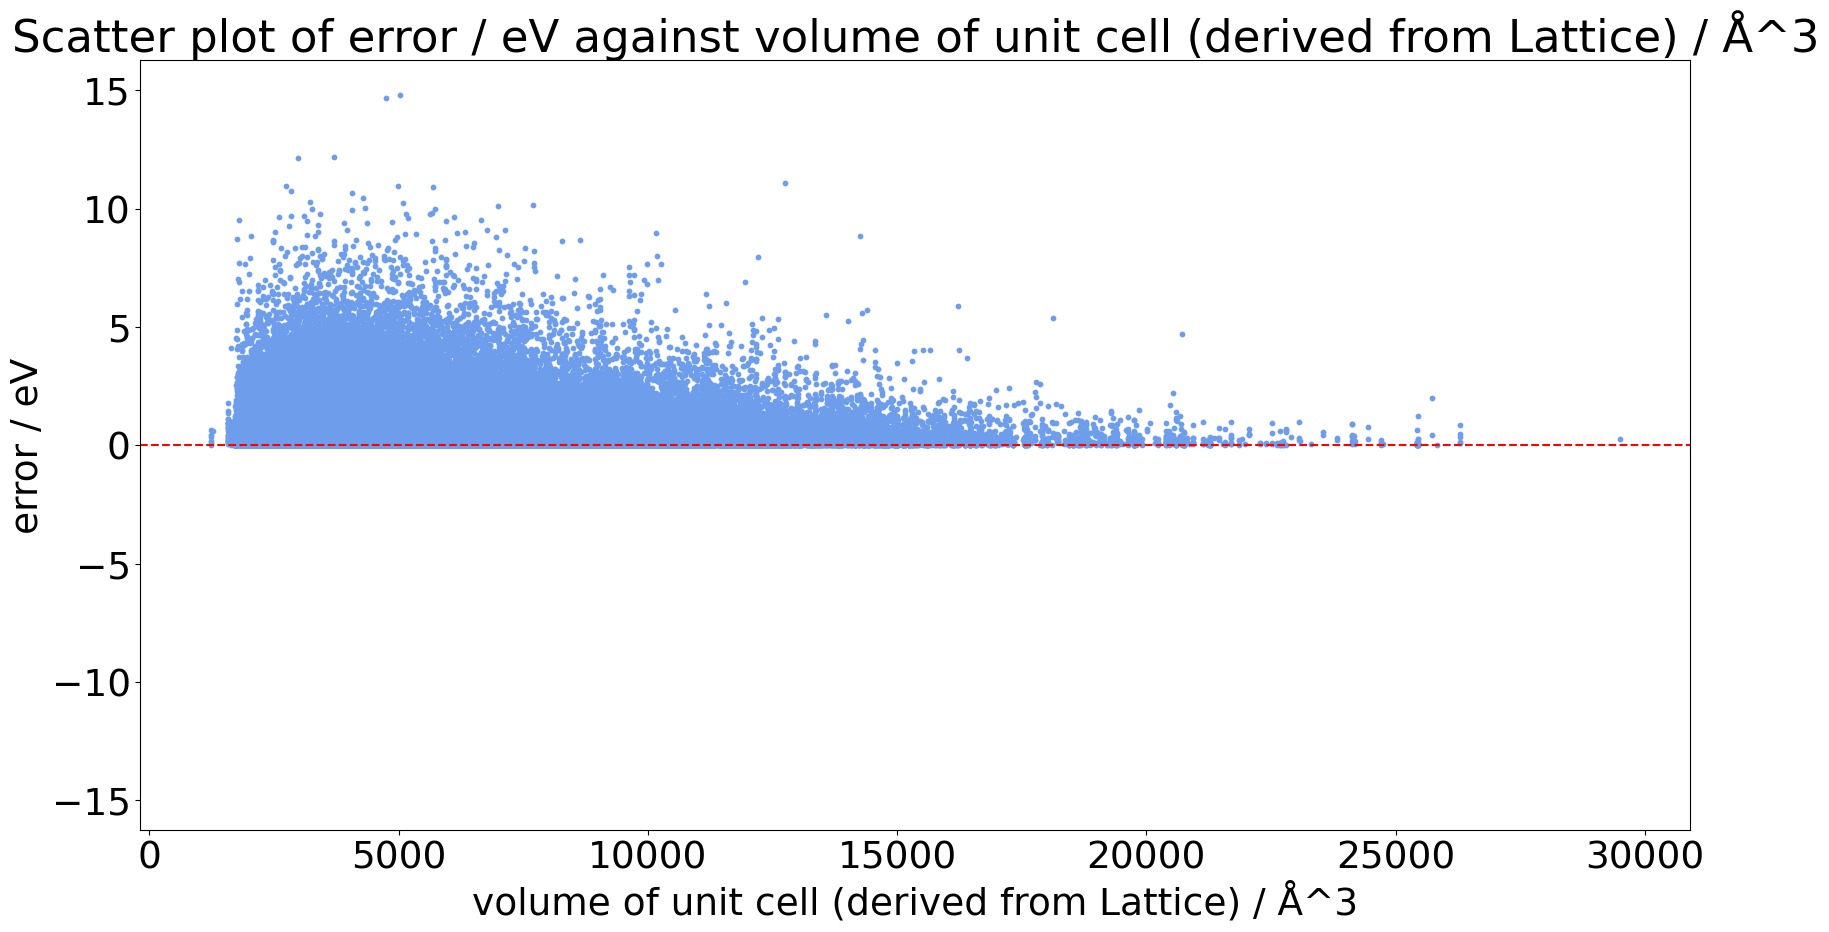

In [15]:
plot_scatter_sorted(df, "volume of unit cell (derived from Lattice) / Å^3")

Moving average

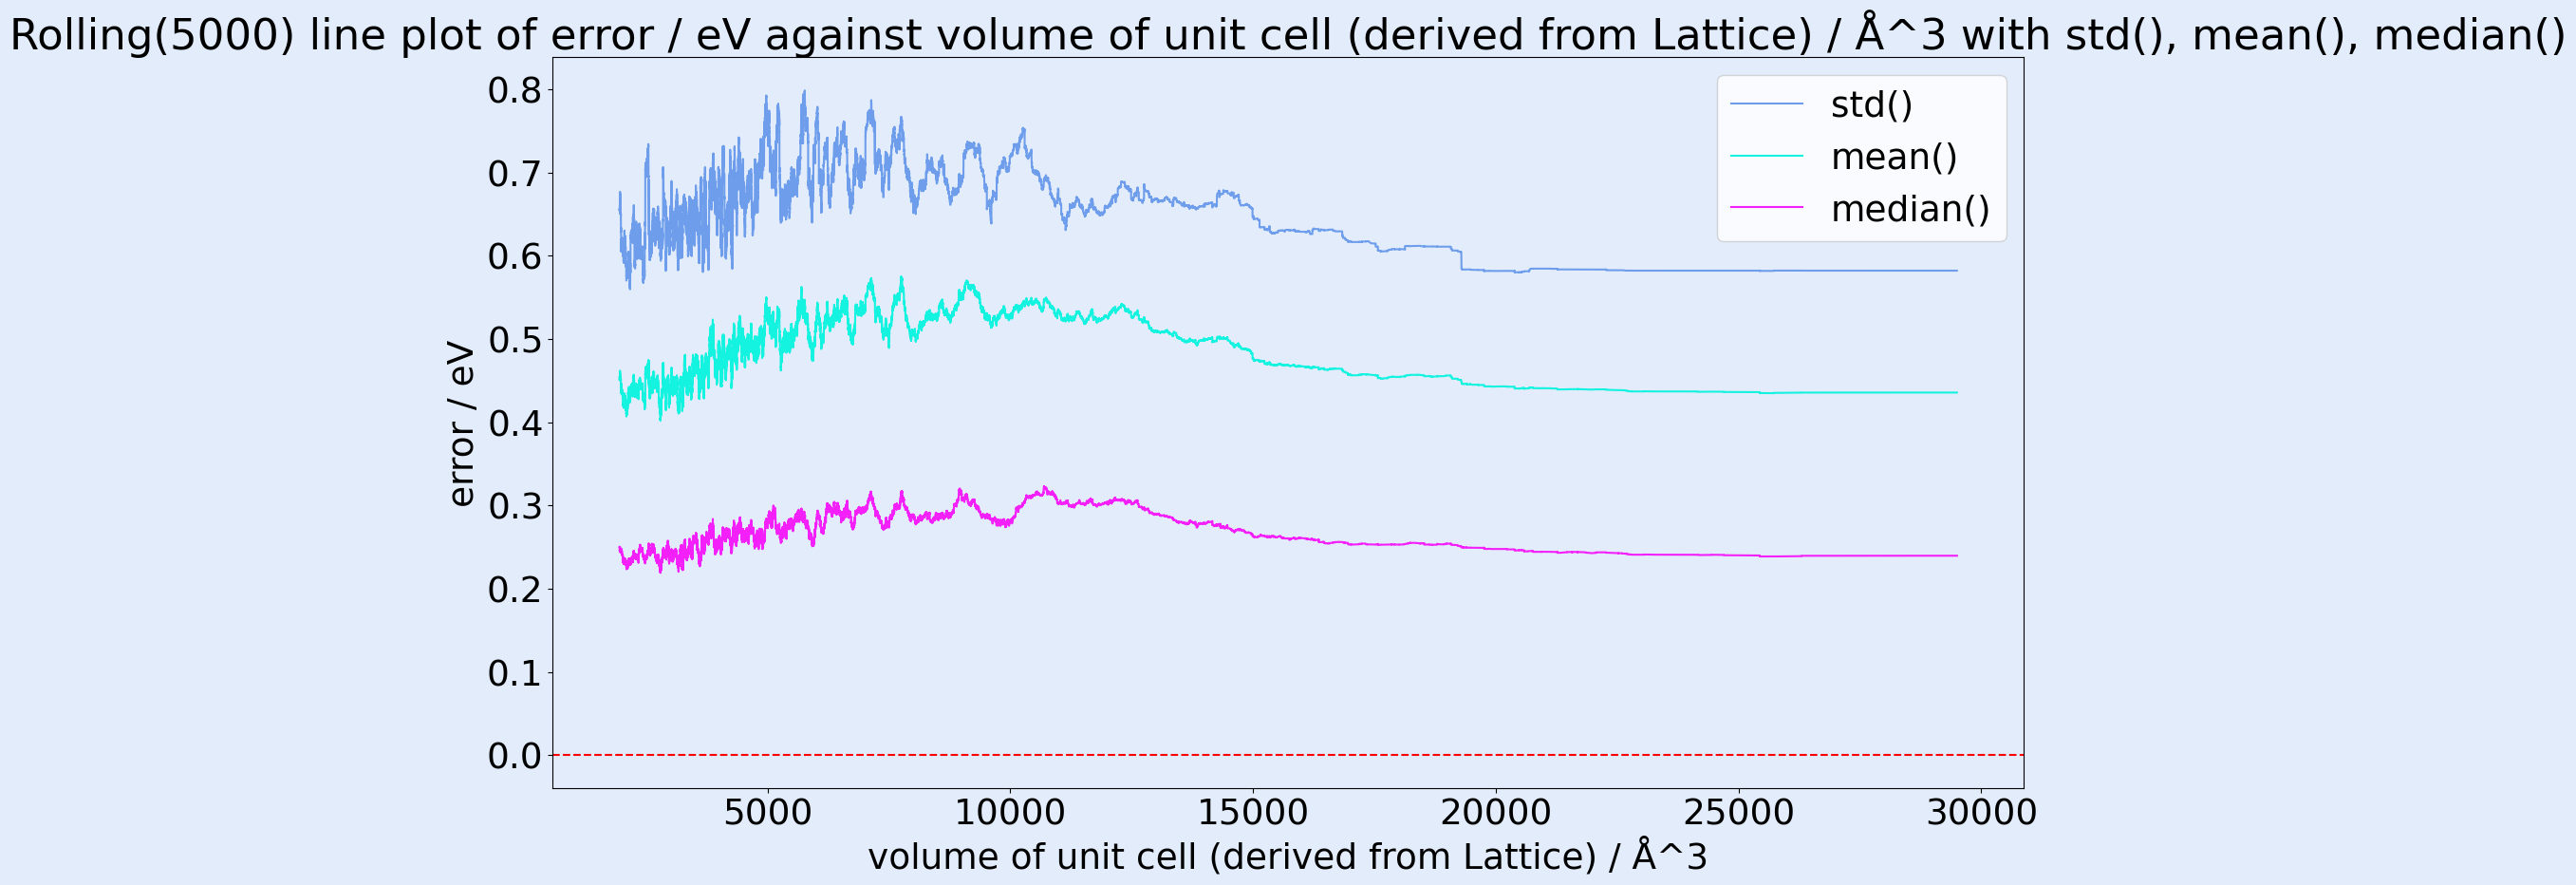

In [7]:
rolling_sorted_multiplot(df, "volume of unit cell (derived from Lattice) / Å^3", 5000)

# Distribution of Error (abs) when Sorted by Element Present (Weighted and Unweighted by number of atoms)

In [8]:
#extract list of elements
#element_list = []
#for i in range(len(df)):
#    element_list += dataset_list[i].get_chemical_symbols()
#    element_list = [*set(element_list)]

element_list = ['H',
                                                                                                'B', 'C', 'N', 'O',
                'Na',                                                                           'Al', 'Si', 'P', 'S', 'Cl',
                'K', 'Ca',      'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',      'Ga', 'Ge', 'As', 'Se',
                'Rb', 'Sr',     'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd',      'In', 'Sn', 'Sb', 'Te', 
                'Cs',           'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg',            'Tl', 'Pb', 'Bi']

element_df = pd.DataFrame(data={"symbol":element_list, "frequency":0, "unweighted_mean_errors / eV":0, "unweighted_mean_abs_errors / eV":0, "weighted_mean_errors / eV":0, "weighted_mean_abs_errors / eV":0})

for element in element_df.index:    
    display(element_df,clear=True)
    df_filtered = df[df['chemical formula'].str.contains(element_df.loc[element, "symbol"])].reset_index(drop=True)

    element_df.loc[element, "frequency"] = len(df_filtered)

    element_df.loc[element, "unweighted_mean_errors / eV"] = df_filtered["error / eV"].mean()
    element_df.loc[element, "unweighted_mean_abs_errors / eV"] = df_filtered["error / eV"].abs().mean()

    for i in range(len(df_filtered)):
        number_of_element_atom = df_filtered.loc[i, 'chemical formula list'].count(element_df.loc[element, "symbol"])

        weight = number_of_element_atom/df_filtered.loc[i, "number of atoms"]
        element_df.loc[element, "weighted_mean_errors / eV"] += df_filtered.loc[i, "error / eV"] * weight / len(df_filtered)
        element_df.loc[element, "weighted_mean_abs_errors / eV"] += abs(df_filtered.loc[i, "error / eV"]) * weight / len(df_filtered)

display(element_df,clear=True)        

,symbol,frequency,unweighted_mean_errors / eV,unweighted_mean_abs_errors / eV,weighted_mean_errors / eV,weighted_mean_abs_errors / eV
0,H,378922,-0.019817,0.461235,-0.001600,0.025864
1,B,10024,-0.024642,0.419941,-0.002586,0.014507
2,C,348795,-0.014919,0.461594,-0.000207,0.015359
3,N,178590,-0.031265,0.573317,-0.001679,0.044604
4,O,310952,-0.026288,0.519804,-0.000412,0.010501
5,Na,13223,0.003414,0.402491,0.003092,0.139262
6,Al,40268,-0.020268,0.477242,-0.010110,0.201377
7,Si,37767,-0.022944,0.526298,-0.009084,0.207116
8,P,87122,-0.015475,0.420963,-0.003881,0.077501
9,S,173261,-0.021183,0.541052,-0.002454,0.085391


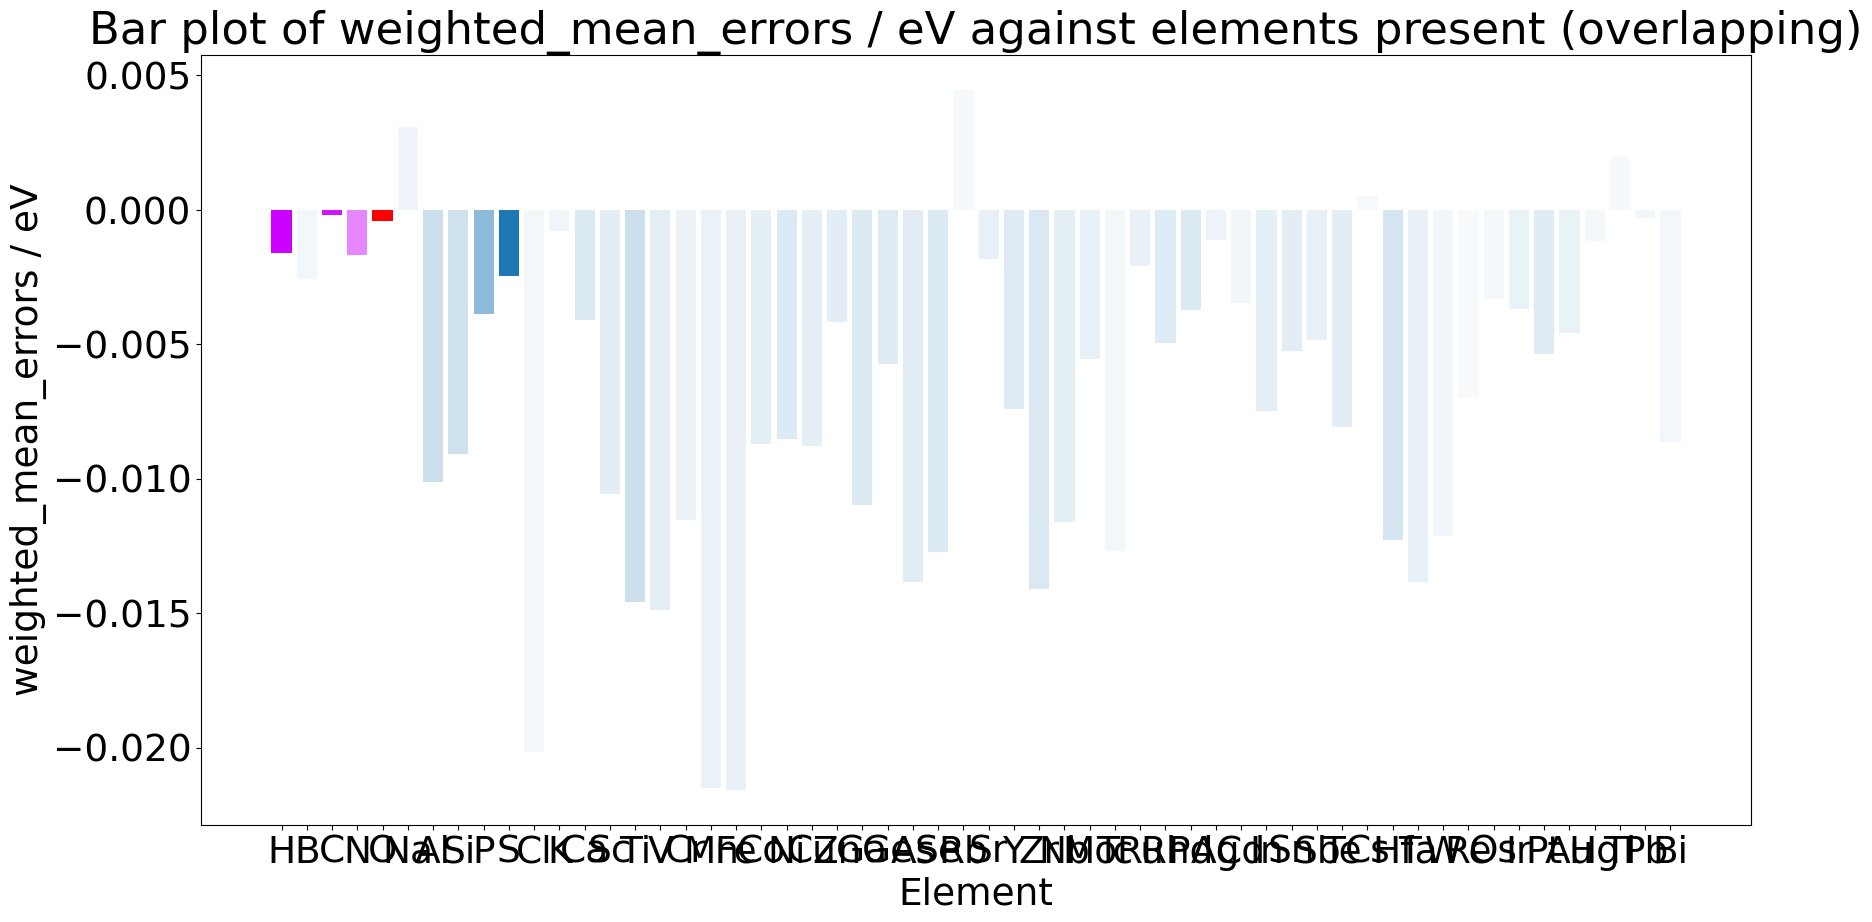

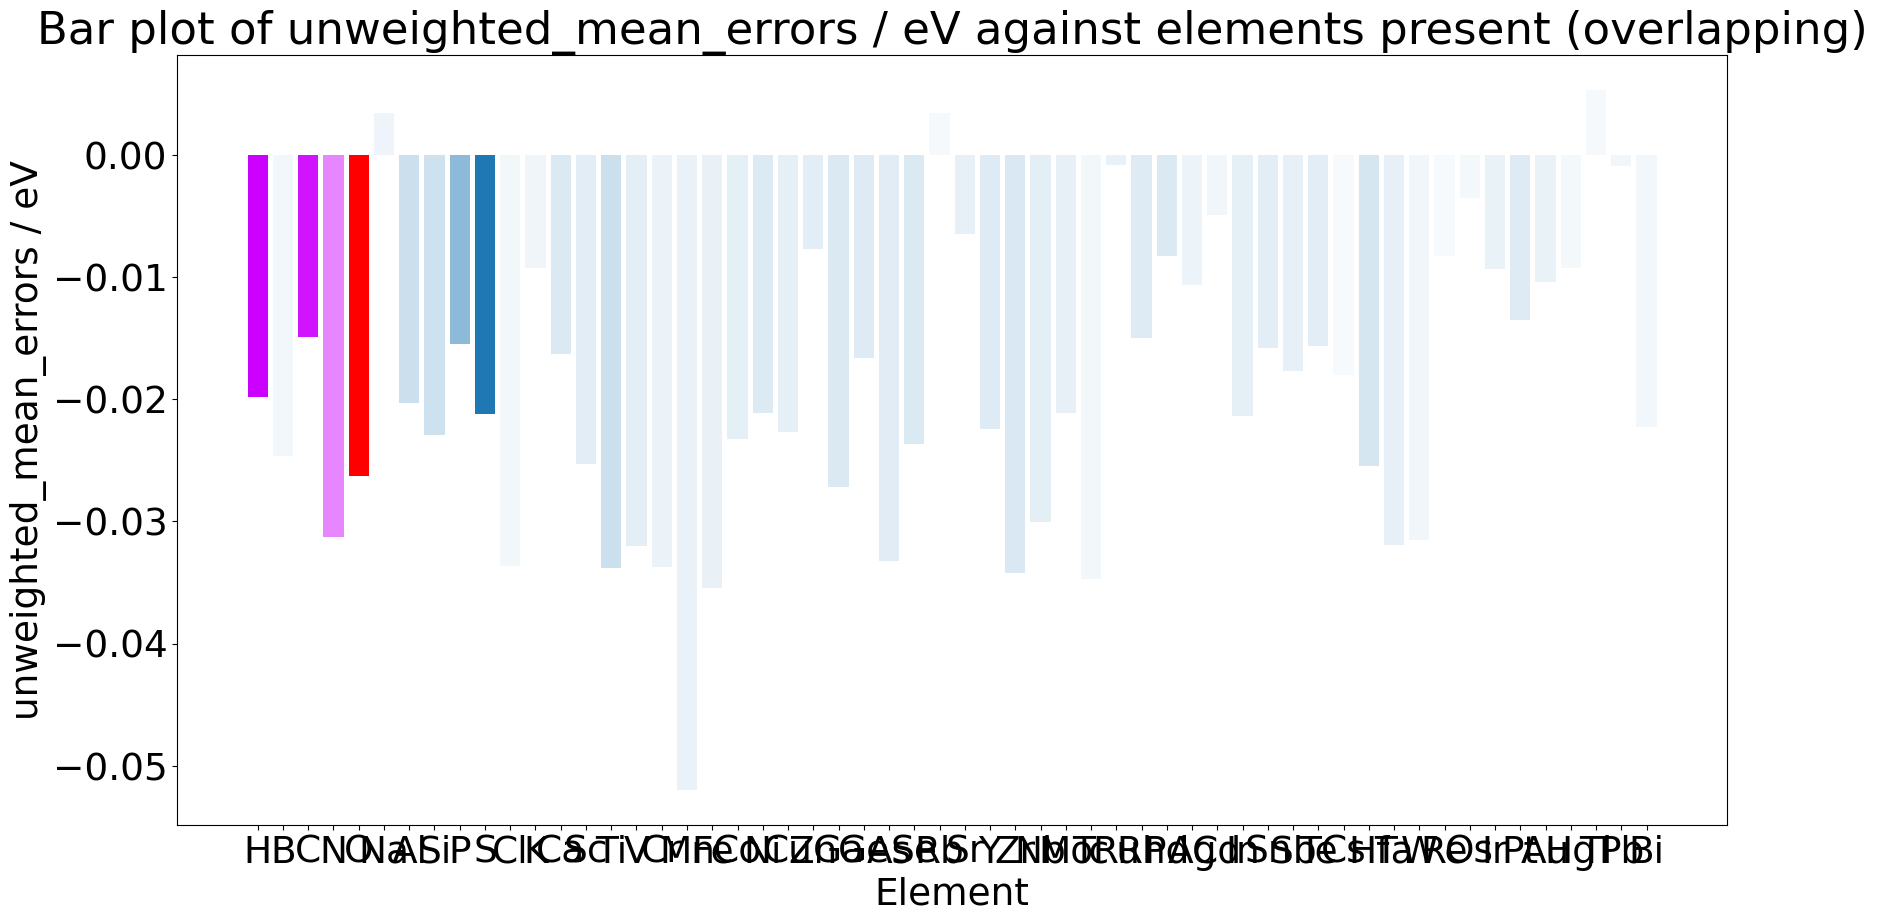

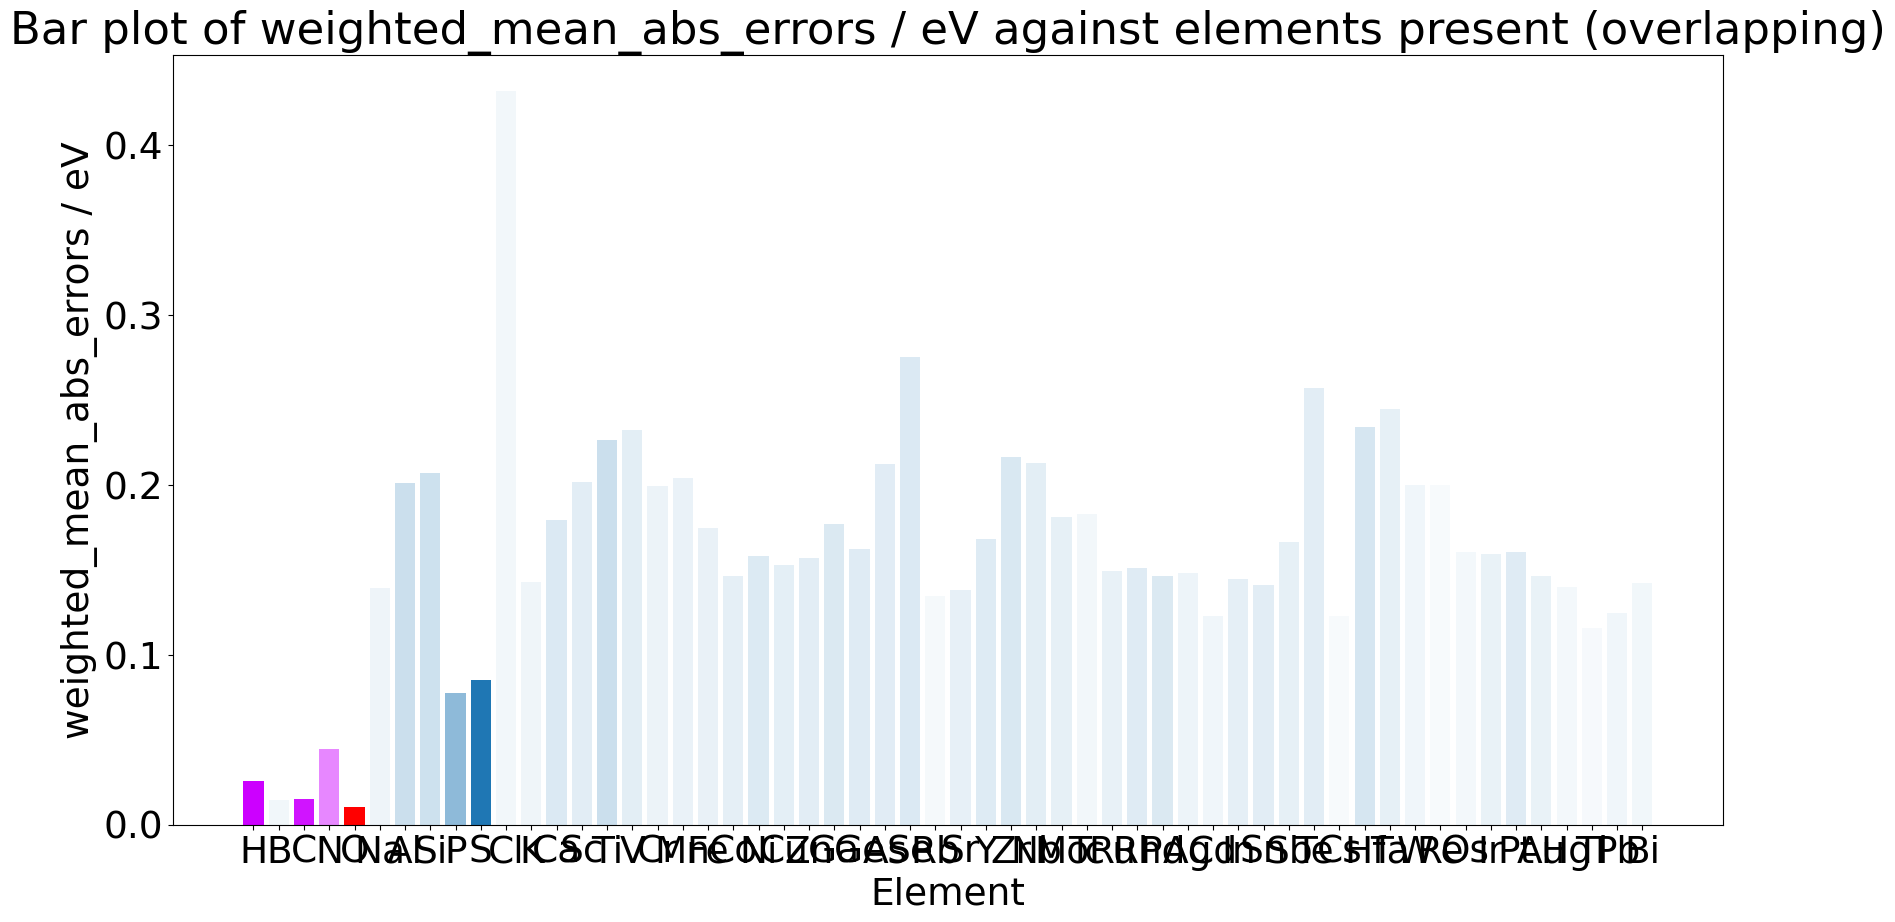

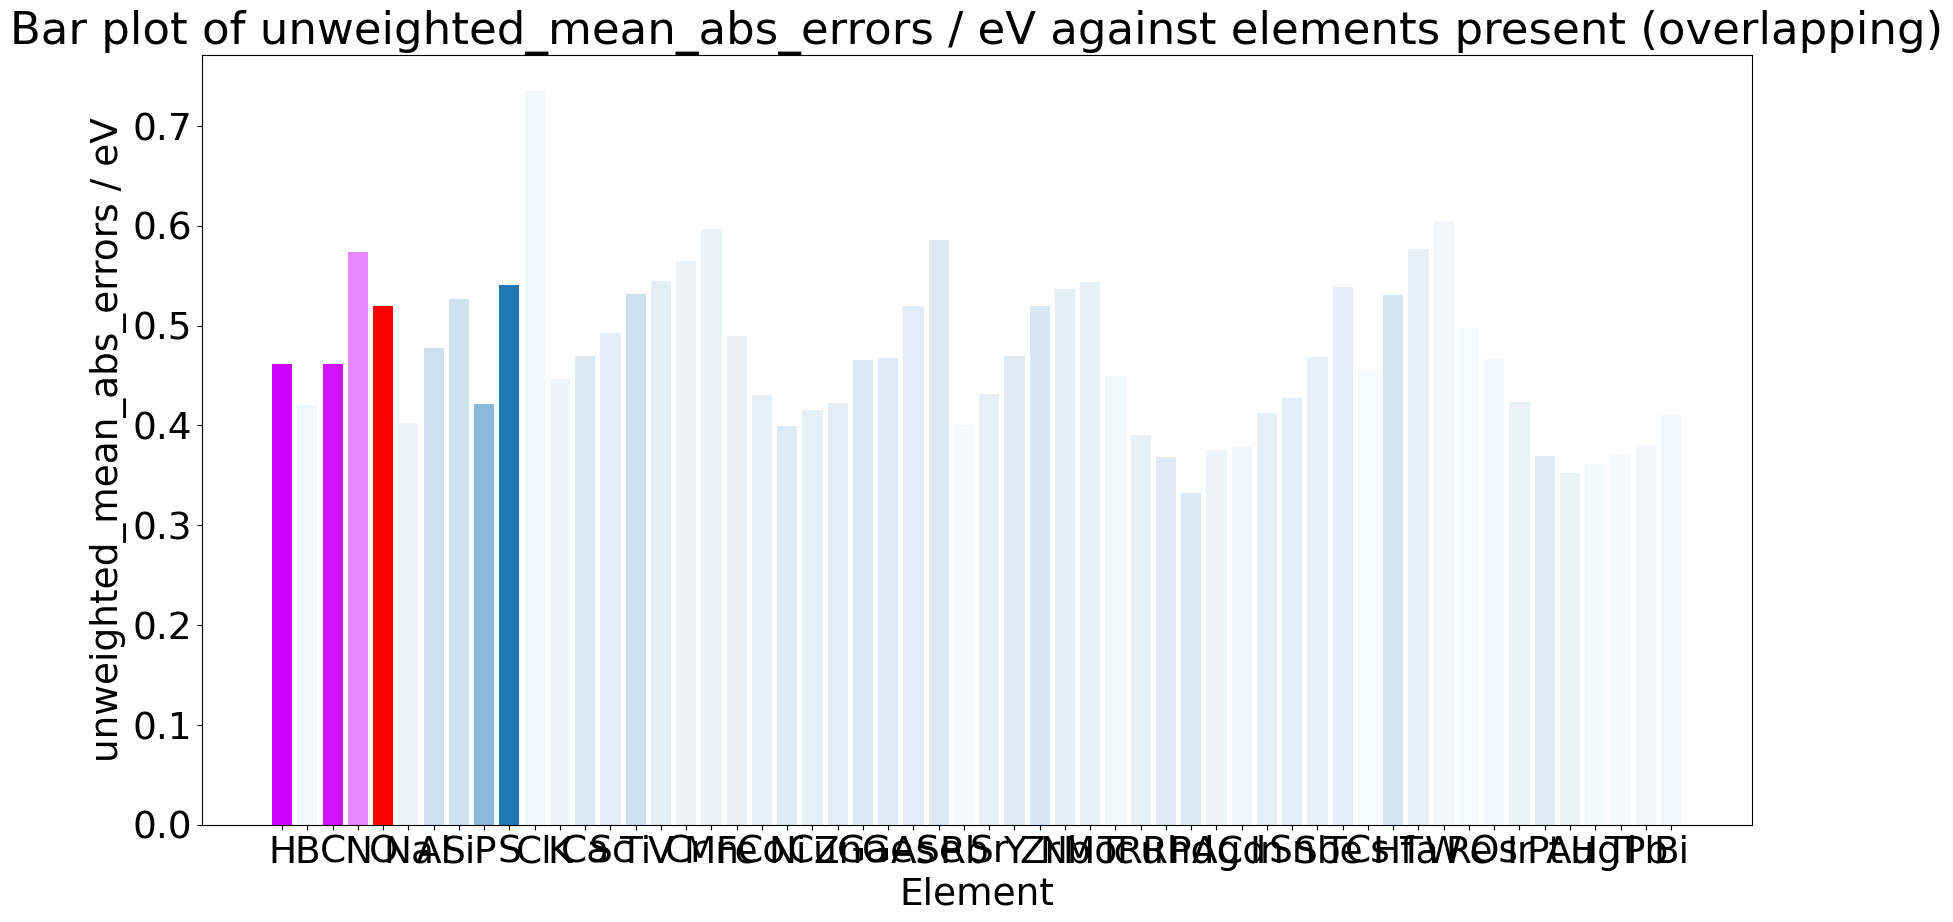

In [9]:
plot_element(element_df, "weighted_mean_errors / eV")
plot_element(element_df, "unweighted_mean_errors / eV")
plot_element(element_df, "weighted_mean_abs_errors / eV")
plot_element(element_df, "unweighted_mean_abs_errors / eV")

In [56]:
element_group_df = pd.DataFrame()
element_group_df["1"] = element_df[(element_df["symbol"]=="H") | (element_df["symbol"]=="Na") | (element_df["symbol"]=="K") | (element_df["symbol"]=="Rb") | (element_df["symbol"]=="Cs")].mean(numeric_only=True)
element_group_df["2"] = element_df[(element_df["symbol"]=="Ca") | (element_df["symbol"]=="Sr")].mean(numeric_only=True)
element_group_df["3"] = element_df[(element_df["symbol"]=="Sc") | (element_df["symbol"]=="Y")].mean(numeric_only=True)
element_group_df["4"] = element_df[(element_df["symbol"]=="Ti") | (element_df["symbol"]=="Zr") | (element_df["symbol"]=="Hf")].mean(numeric_only=True)
element_group_df["5"] = element_df[(element_df["symbol"]=="V") | (element_df["symbol"]=="Nb") | (element_df["symbol"]=="Ta")].mean(numeric_only=True)
element_group_df["6"] = element_df[(element_df["symbol"]=="Cr") | (element_df["symbol"]=="Mo") | (element_df["symbol"]=="W")].mean(numeric_only=True)
element_group_df["7"] = element_df[(element_df["symbol"]=="Mn") | (element_df["symbol"]=="Tc") | (element_df["symbol"]=="Re")].mean(numeric_only=True)
element_group_df["8"] = element_df[(element_df["symbol"]=="Fe") | (element_df["symbol"]=="Ru") | (element_df["symbol"]=="Os")].mean(numeric_only=True)
element_group_df["9"] = element_df[(element_df["symbol"]=="Co") | (element_df["symbol"]=="Rh") | (element_df["symbol"]=="Ir")].mean(numeric_only=True)
element_group_df["10"] = element_df[(element_df["symbol"]=="Ni") | (element_df["symbol"]=="Pd") | (element_df["symbol"]=="Pt")].mean(numeric_only=True)
element_group_df["11"] = element_df[(element_df["symbol"]=="Cu") | (element_df["symbol"]=="Ag") | (element_df["symbol"]=="Au")].mean(numeric_only=True)
element_group_df["12"] = element_df[(element_df["symbol"]=="Zn") | (element_df["symbol"]=="Cd") | (element_df["symbol"]=="Hg")].mean(numeric_only=True)
element_group_df["13"] = element_df[(element_df["symbol"]=="B") | (element_df["symbol"]=="Al") | (element_df["symbol"]=="Ga") | (element_df["symbol"]=="In") | (element_df["symbol"]=="Tl")].mean(numeric_only=True)
element_group_df["14"] = element_df[(element_df["symbol"]=="C") | (element_df["symbol"]=="Si") | (element_df["symbol"]=="Ge") | (element_df["symbol"]=="Sn") | (element_df["symbol"]=="Pb")].mean(numeric_only=True)
element_group_df["15"] = element_df[(element_df["symbol"]=="N") | (element_df["symbol"]=="P") | (element_df["symbol"]=="As") | (element_df["symbol"]=="Sb") | (element_df["symbol"]=="Bi")].mean(numeric_only=True)
element_group_df["16"] = element_df[(element_df["symbol"]=="O") | (element_df["symbol"]=="S") | (element_df["symbol"]=="Se") | (element_df["symbol"]=="Te")].mean(numeric_only=True)
element_group_df["17"] = element_df[(element_df["symbol"]=="Cl")].mean(numeric_only=True)
element_group_df = element_group_df.transpose()
display(element_group_df)


,frequency,unweighted_mean_errors / eV,unweighted_mean_abs_errors / eV,weighted_mean_errors / eV,weighted_mean_abs_errors / eV
1,83533.400000,-0.008061,0.432831,0.001139,0.113091
2,22885.500000,-0.011401,0.450499,-0.002957,0.158984
3,23725.000000,-0.023880,0.481011,-0.008984,0.185037
4,33477.666667,-0.031153,0.527502,-0.013661,0.225703
5,20416.000000,-0.031337,0.552542,-0.013446,0.230179
6,14818.000000,-0.028800,0.570602,-0.009742,0.193583
7,10390.000000,-0.031639,0.514552,-0.013719,0.195672
8,14521.666667,-0.013240,0.448951,-0.009001,0.161601
9,20387.000000,-0.015853,0.407360,-0.005779,0.152293
10,26199.333333,-0.014315,0.366946,-0.005871,0.155022


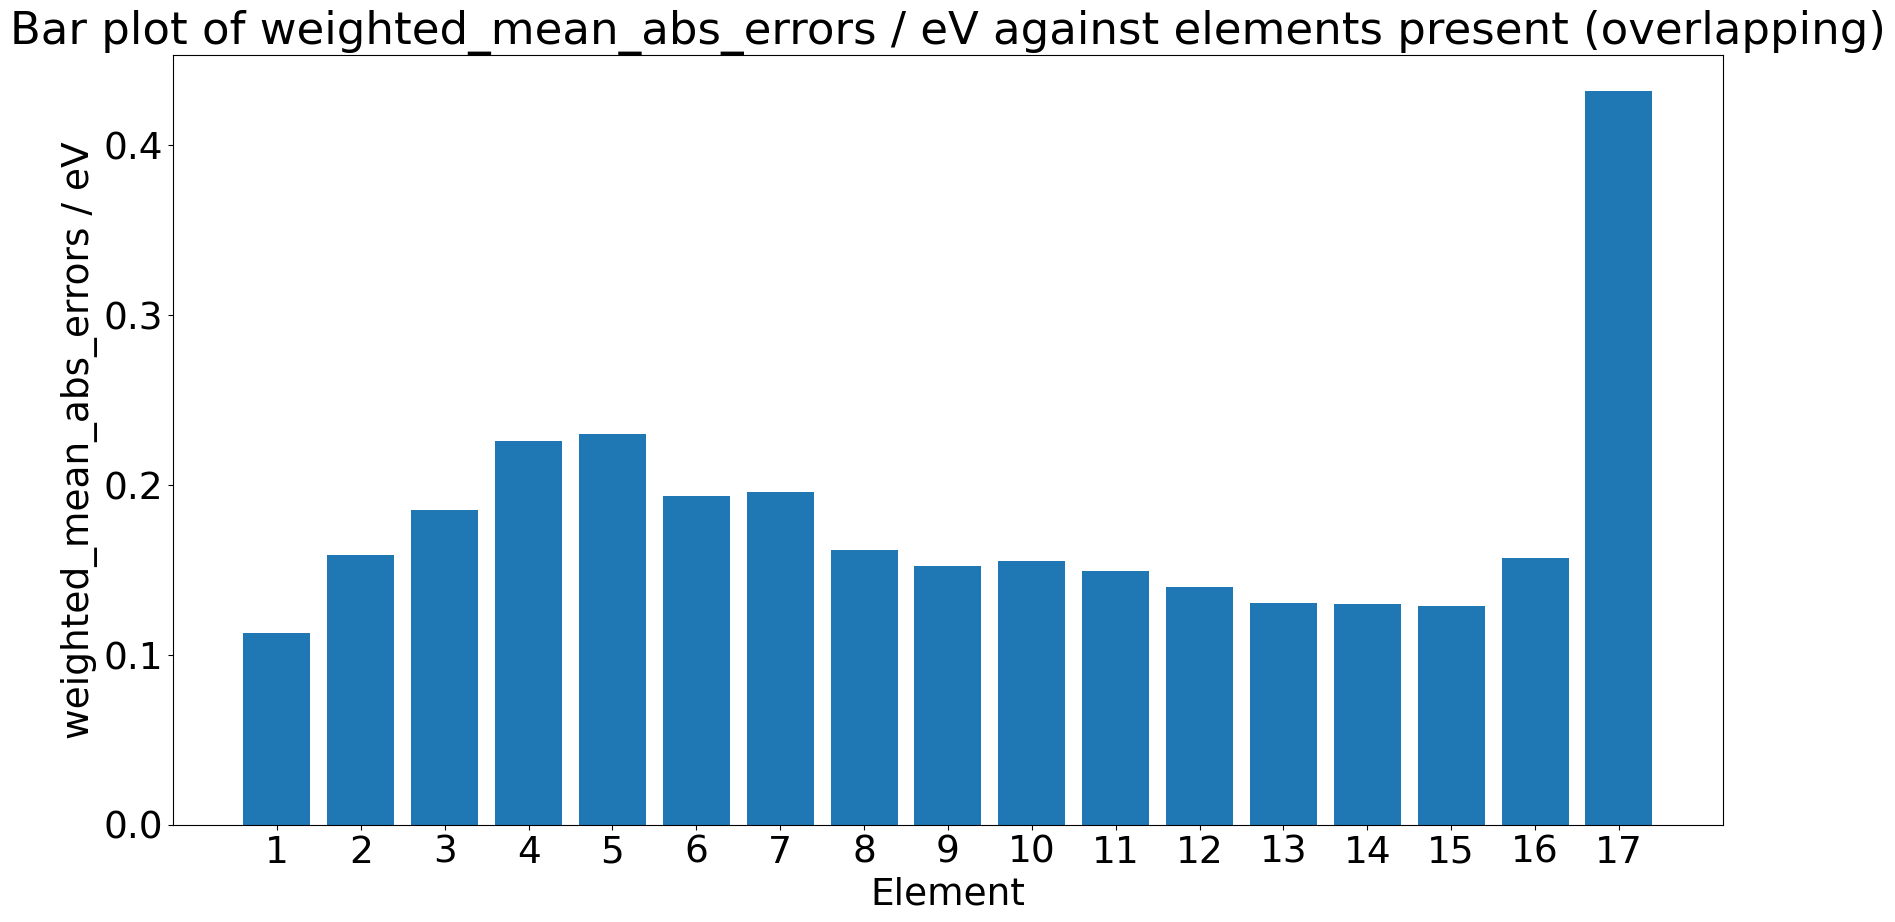

In [59]:
plt.figure(figsize=(FIGURE_SIZE_X,FIGURE_SIZE_Y))
plt.title(f"Bar plot of weighted_mean_abs_errors / eV against elements present (overlapping)")
plt.xlabel('Element')
plt.ylabel("weighted_mean_abs_errors / eV")
plt.bar(element_group_df.index,
        element_group_df["weighted_mean_abs_errors / eV"])
        color=[(1, 0, 0, 1) if element_df.loc[element, "symbol"] == "O"
                else (0.8, 0, 1, element_df.loc[element, "frequency"]/element_df.loc[0, "frequency"]) if element_df.loc[element, "symbol"] == "C" or element_df.loc[element, "symbol"] == "N" or element_df.loc[element, "symbol"] == "H"
                else (31/255, 119/255, 180/255, element_df.loc[element, "frequency"]/element_df.loc[9, "frequency"])  
                for element in element_df.index])
plt.show()

In [10]:
ptable_plotter(element_df["symbol"], element_df["unweighted_mean_errors / eV"])
ptable_plotter(element_df["symbol"], element_df["weighted_mean_errors / eV"])
ptable_plotter(element_df["symbol"], element_df["unweighted_mean_abs_errors / eV"])
ptable_plotter(element_df["symbol"], element_df["weighted_mean_abs_errors / eV"])

# Distribution of Error (abs) when Sorted by adsorbate Present

An attempt to scan for the adsorbate

In [11]:
# LOOKS LIKE O WAS THE NON-CATALYST ELEMENT, NOT H
# adsorbate_list = []
# for i in range(len(df)):
#         adsorbate = []
#         elements_tail_12 = df.loc[i, "chemical formula list"][-12:]
#         for element in elements_tail_12:
#                 if element == "H" or element == "O" or element == "N" or element == "C":
#                         adsorbate.append(element)
#         adsorbate_list.append(adsorbate)     

# adsorbate_list = [adsorbate for adsorbate in adsorbate_list if adsorbate.count("C") <= 2 and adsorbate.count("N") <= 3 and adsorbate.count("H") <= 8]

# adsorbate_list.sort()
# adsorbate_list = list(adsorbate_list for adsorbate_list,_ in itertools.groupby(adsorbate_list))
# adsorbate_list.remove([])
# print(len(adsorbate_list))
# print(adsorbate_list)

In [12]:
# painfully added manually :(
adsorbate_list = [['H'], ['O'], ['O', 'H'], ['H', 'H', 'O'],

                  ['C?'],
                  ['C'], ['C', 'O'], ['H', 'C'], ['C', 'H', 'O'], ['C', 'H', 'H'], ['C', 'H', 'H', 'O'],
                  ['C', 'H', 'H', 'H'], ['C', 'H', 'H', 'H', 'O'], ['H', 'H', 'H', 'H', 'C'], ['C', 'H', 'H', 'H', 'H', 'O'], 

                  ['C', 'C'], ['C', 'C', 'O'], ['C', 'C', 'H'], ['H', 'C', 'C', 'O'], ['C', 'C', 'H', 'O', 'O'],
                  ['C', 'C', 'H', 'H', 'O'], ['C', 'C', 'H', 'H'],
                  ['C', 'C', 'H', 'H', 'O', 'O'],
                  ['C', 'C', 'H', 'H', 'H'], ['C', 'C', 'H', 'H', 'H', 'O'],
                  ['C', 'C', 'H', 'H', 'H', 'O', 'O'],
                  ['H', 'H', 'H', 'H', 'C', 'C'], ['C', 'C', 'H', 'H', 'H', 'H', 'O'],
                  ['C', 'C', 'H', 'H', 'H', 'H', 'O', 'O'],
                  ['H', 'H', 'H', 'H', 'H', 'C', 'C'],
                  ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'O'], ['C', 'C', 'H', 'H', 'H', 'H', 'H', 'O', 'O'],
                  ['H', 'H', 'H', 'H', 'H', 'H', 'C', 'C', 'O'], 

                  ['N?'],
                  ['N', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H'], ['N', 'N', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'O'], ['N', 'N', 'O', 'H', 'H', 'H', 'H', 'C'], ['N', 'N', 'C', 'H', 'H', 'H'], ['O', 'N', 'H'],
                  ['N', 'N', 'H', 'H'], ['N', 'N', 'N', 'H'], ['N', 'N', 'H'], ['N', 'N', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'N', 'N'], ['N', 'N', 'O'],
                  ['N', 'N'], ['N', 'N', 'H', 'H', 'O'], ['H', 'H', 'N'], ['N', 'H', 'H', 'H'], ['N', 'N', 'H', 'O'], ['N', 'H'], ['N', 'O', 'O'], ['N', 'O'], ['N'],
                  ['N', 'O', 'O', 'O'], ['N', 'H', 'H', 'H', 'O'], ['N', 'H', 'O', 'O'], ['C', 'N']]

adsorbate_df = pd.DataFrame(data={"formula list":[i for i in adsorbate_list], "len":[0 if adsorbate == ['C?'] or adsorbate == ['N?'] else len(adsorbate) for adsorbate in adsorbate_list], "frequency":0, "mean_errors / eV":0, "mean_abs_errors / eV":0})
adsorbate_df.loc[0:3, "adsorbate class"] = 'O/H Only'
adsorbate_df.loc[4:14, "adsorbate class"] = 'C1'
adsorbate_df.loc[15:32, "adsorbate class"] = 'C2'
adsorbate_df.loc[33:, "adsorbate class"] = 'Nitrogen-based'
adsorbate_df.sort_values('len', ascending=False, inplace=True)
df_temp = df
for adsorbate in adsorbate_df.index:
    display(adsorbate_df,clear=True)

    if adsorbate_df.loc[adsorbate, "formula list"] == ['C?'] or adsorbate_df.loc[adsorbate, "formula list"] == ['N?'] or adsorbate_df.loc[adsorbate, "formula list"] == ['H']:
        df_filtered = df_temp[df_temp['chemical formula'].str.contains(adsorbate_df.loc[adsorbate, "formula list"][0][0])].reset_index(drop=True)
        df_temp = df_temp[~(df_temp['chemical formula'].str.contains(adsorbate_df.loc[adsorbate, "formula list"][0][0]))].reset_index(drop=True)

    else:
        df_filtered = df_temp[pd.Series(df_temp.loc[i, "chemical formula list"][-len(adsorbate_df.loc[adsorbate, "formula list"]):] ==
                        adsorbate_df.loc[adsorbate, "formula list"]
                        for i in range(len(df_temp)))].reset_index(drop=True)

        df_temp = df_temp[pd.Series(df_temp.loc[i, "chemical formula list"][-len(adsorbate_df.loc[adsorbate, "formula list"]):] !=
                        adsorbate_df.loc[adsorbate, "formula list"]
                        for i in range(len(df_temp)))].reset_index(drop=True)

    adsorbate_df.loc[adsorbate, "frequency"] = len(df_filtered)
    adsorbate_df.loc[adsorbate, "mean_errors / eV"] = df_filtered["error / eV"].mean()
    adsorbate_df.loc[adsorbate, "mean_abs_errors / eV"] = df_filtered["error / eV"].abs().mean()

adsorbate_df.sort_index(inplace=True)
display(adsorbate_df,clear=True)      

,formula list,len,frequency,mean_errors / eV,mean_abs_errors / eV,adsorbate class
0,[H],1,25613,-0.030906,0.303887,O/H Only
1,[O],1,12692,-0.020398,0.492345,O/H Only
2,"[O, H]",2,8756,-0.010358,0.388637,O/H Only
3,"[H, H, O]",3,13441,-0.037886,0.327079,O/H Only
4,[C?],0,44,-0.090725,1.040597,C1
5,[C],1,11186,0.000807,0.516789,C1
6,"[C, O]",2,674,-0.161755,0.694966,C1
7,"[H, C]",2,1,0.080896,0.080896,C1
8,"[C, H, O]",3,11662,0.007939,0.463955,C1
9,"[C, H, H]",3,8899,0.000564,0.385316,C1


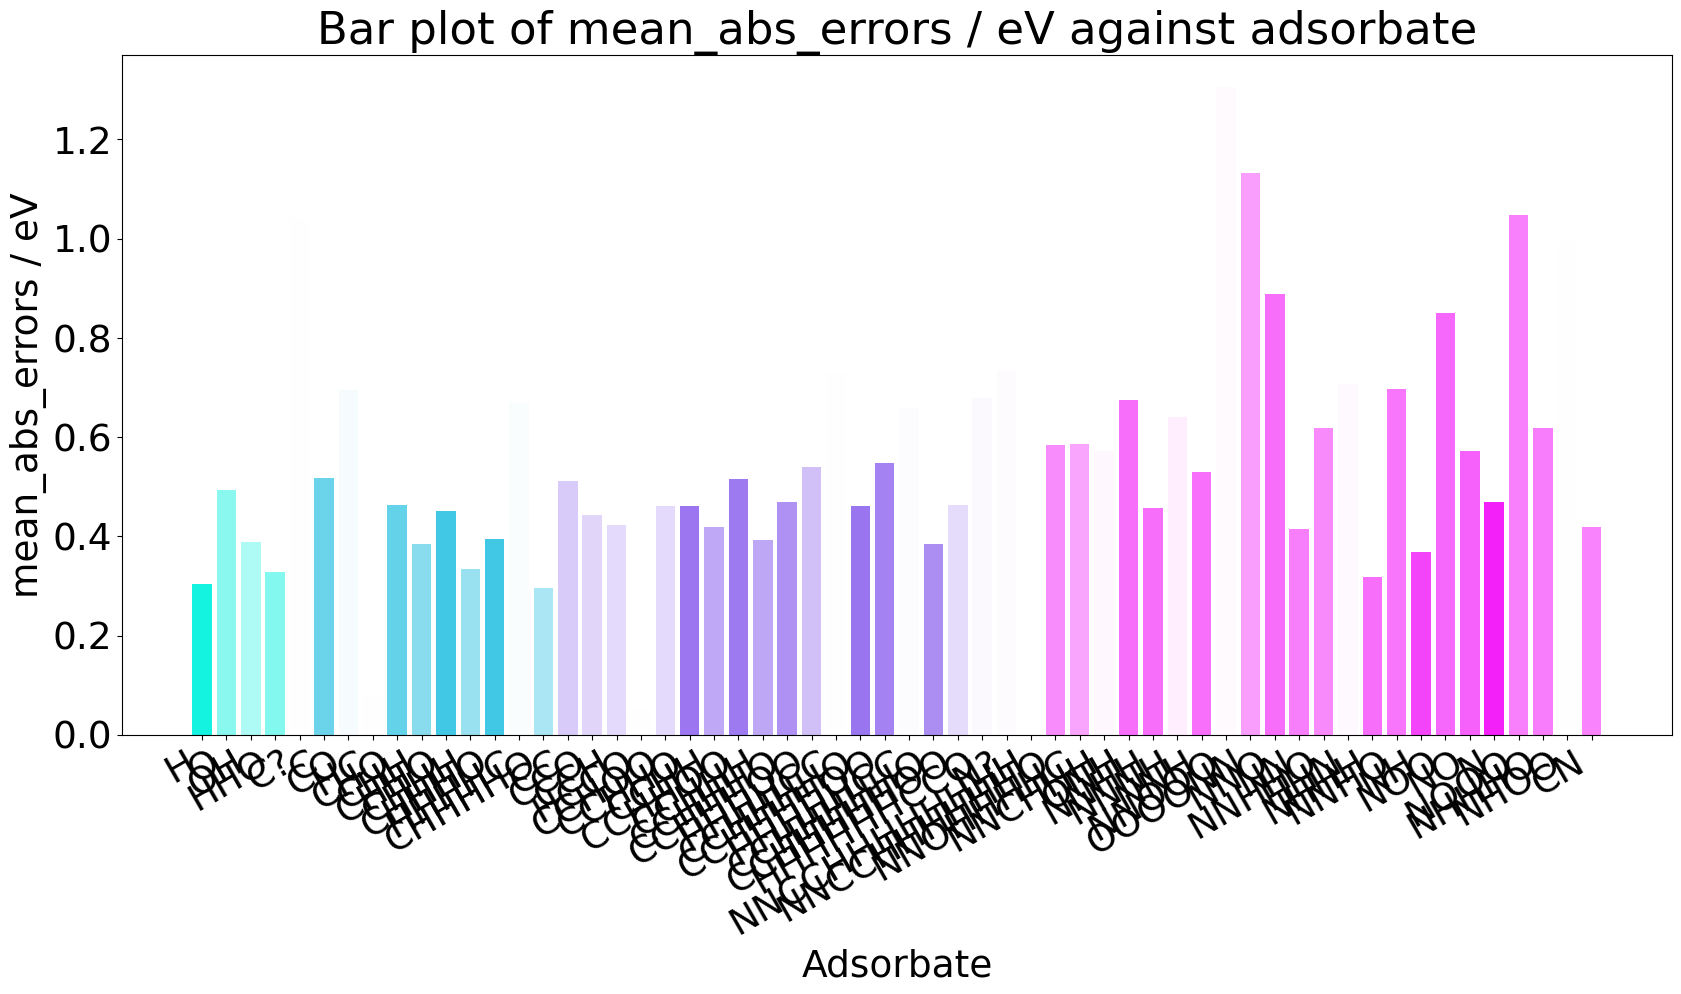

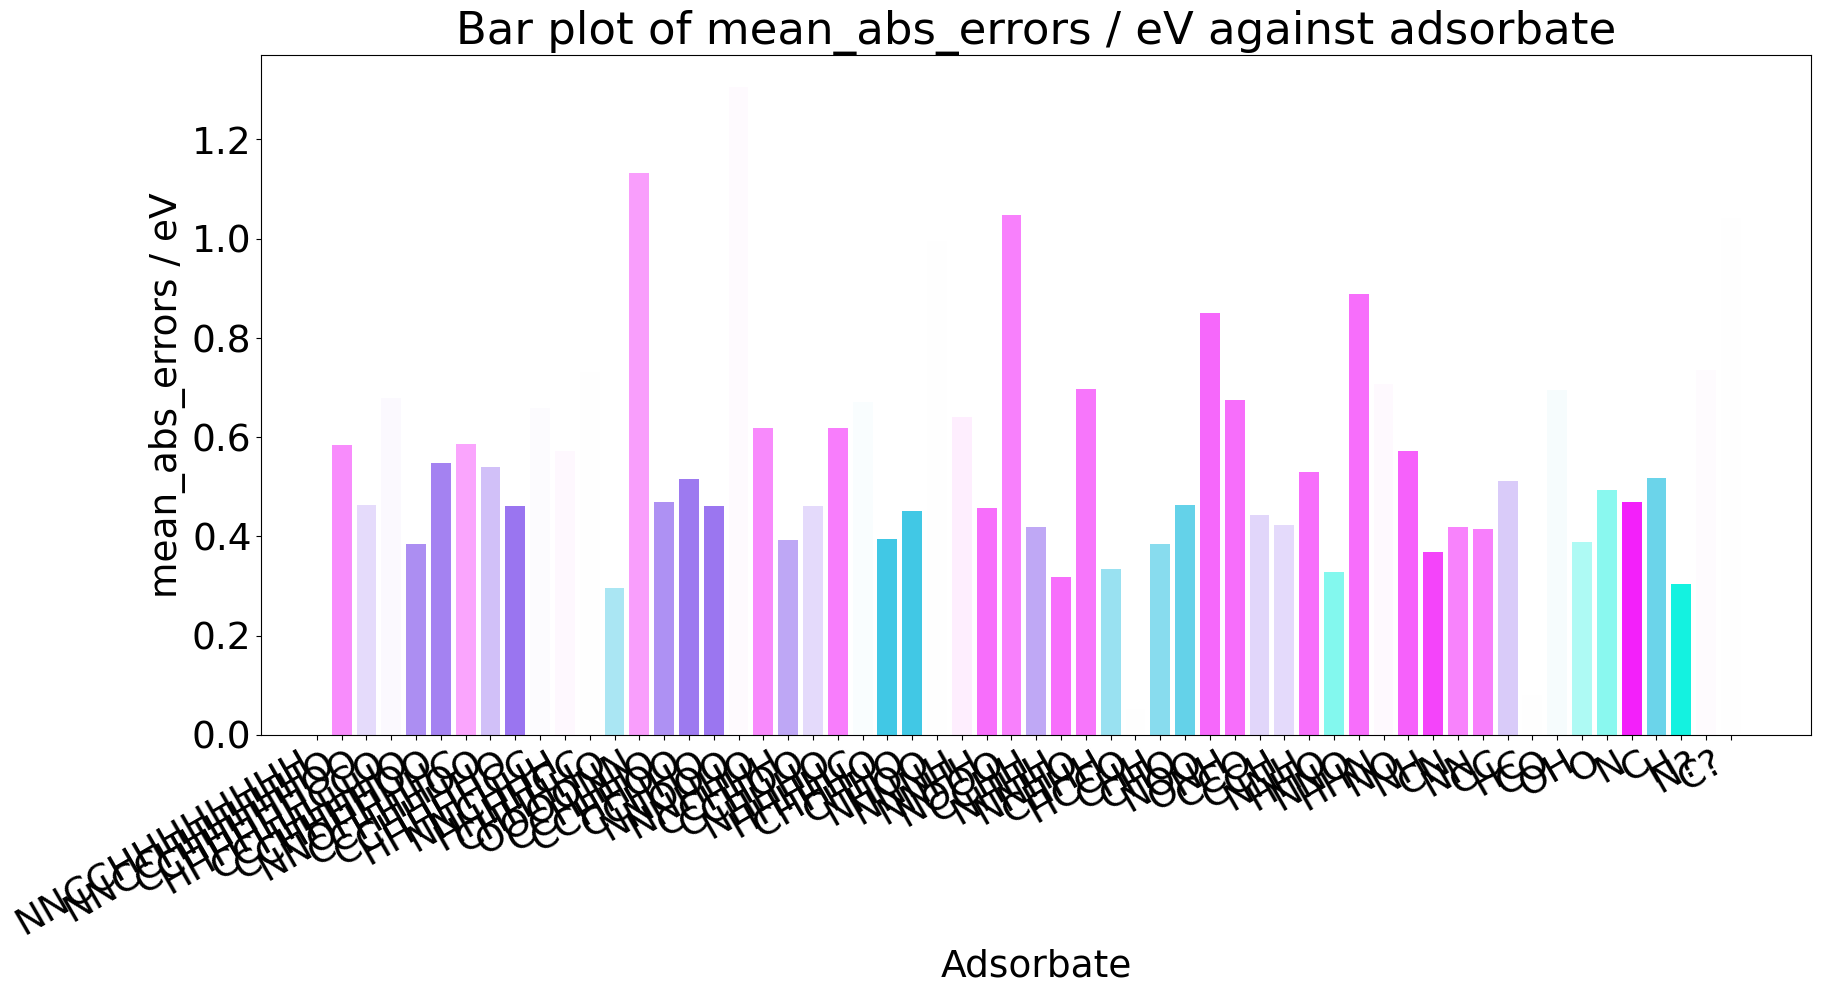

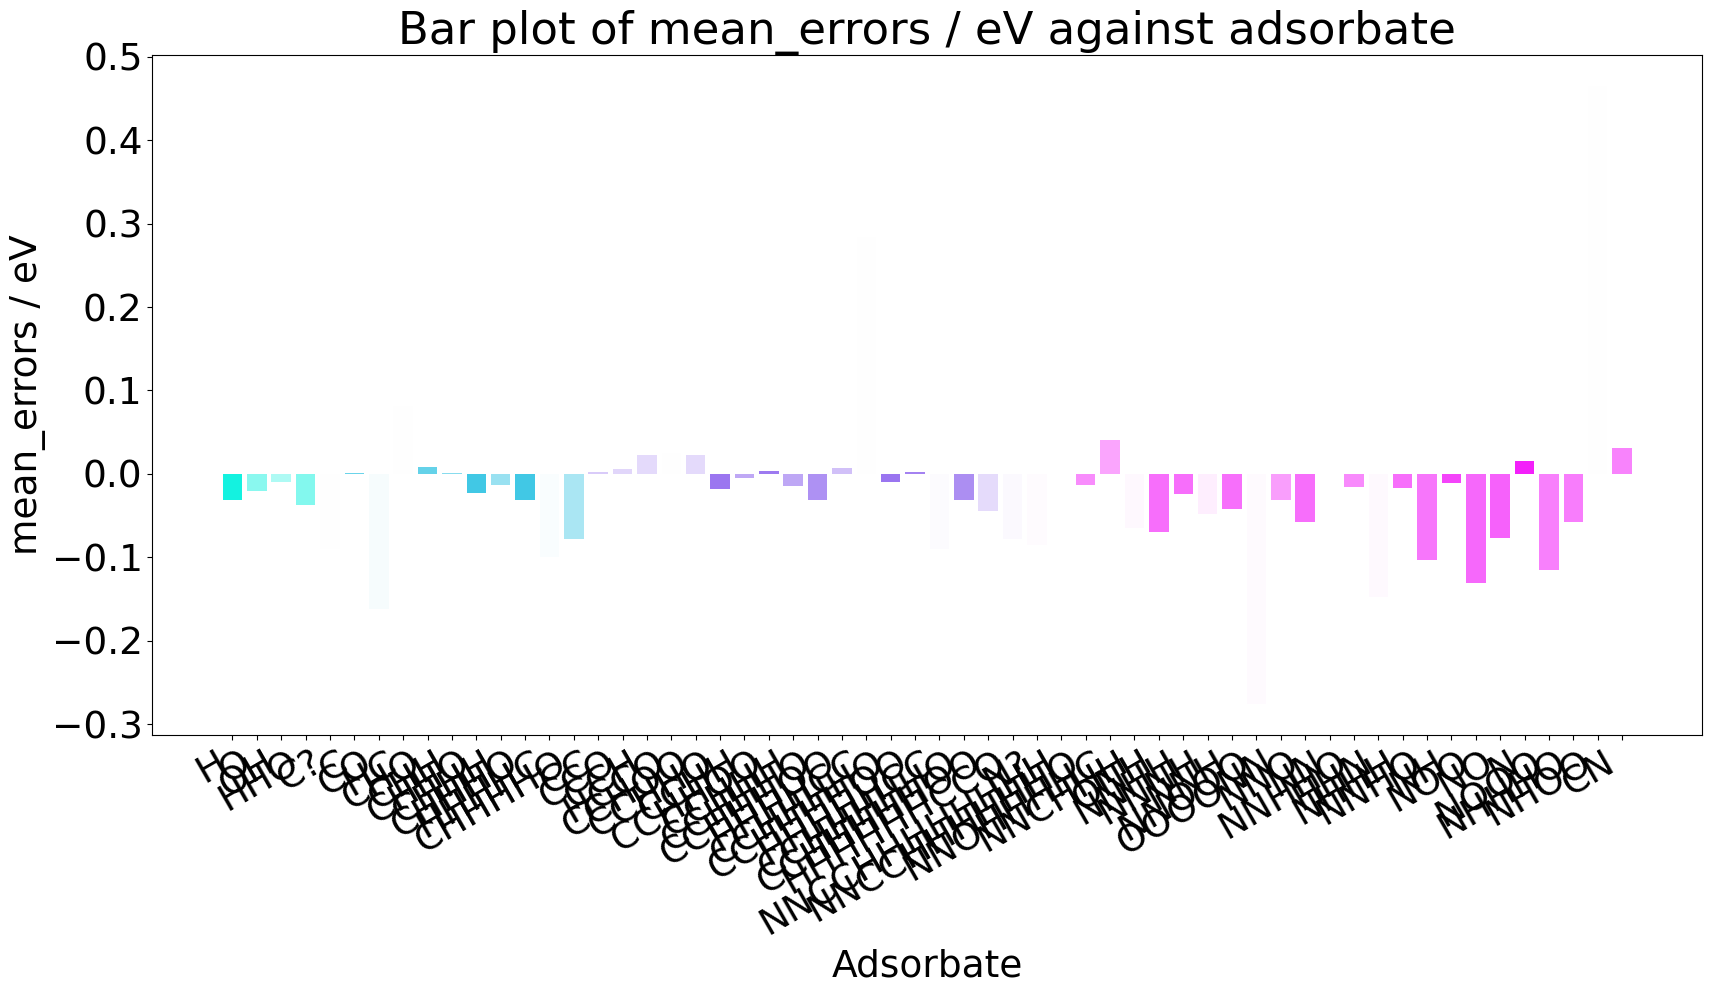

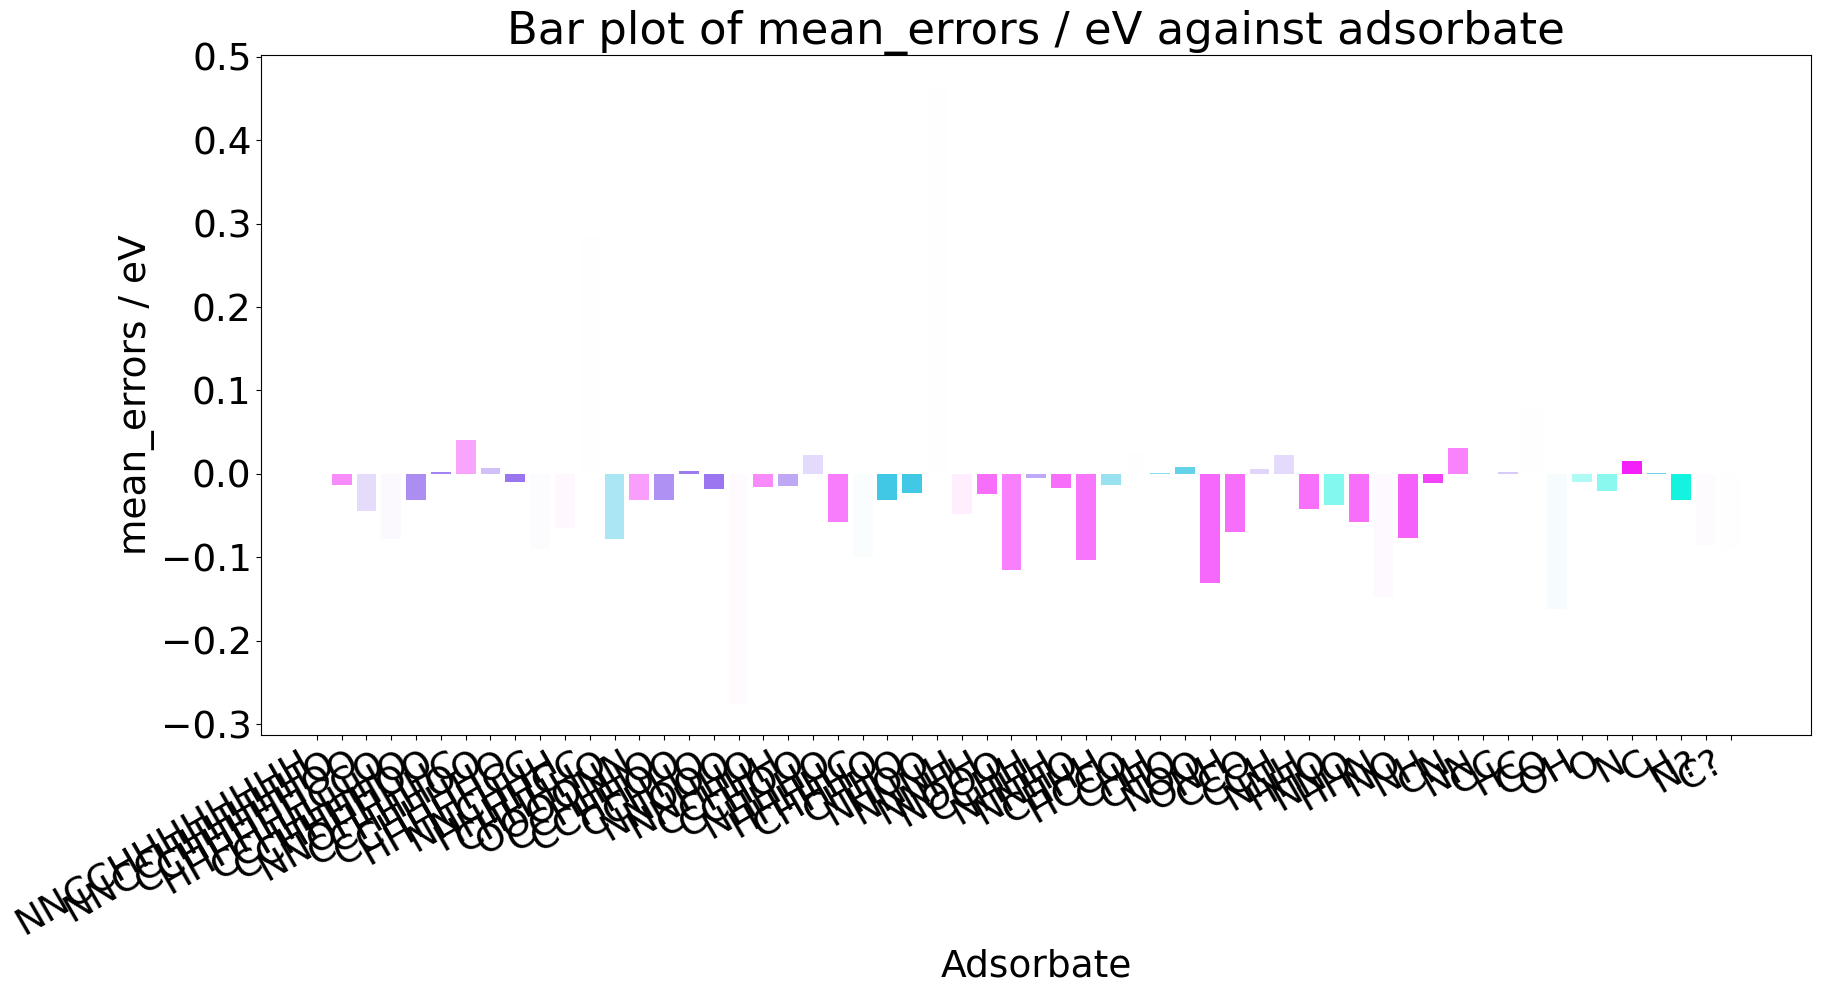

In [13]:
plot_adsorbate(adsorbate_df, "mean_abs_errors / eV")
plot_adsorbate(adsorbate_df.sort_values('len', ascending=False), "mean_abs_errors / eV")

plot_adsorbate(adsorbate_df, "mean_errors / eV")
plot_adsorbate(adsorbate_df.sort_values('len', ascending=False), "mean_errors / eV")